<a href="https://colab.research.google.com/github/Ibraheem101/mlops/blob/main/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Logistic Regression from scratch

In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

In [2]:
SEED = 1234

In [3]:
np.random.seed(SEED)

In [4]:
from pandas.plotting import scatter_matrix

In [5]:
path = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tumors.csv"
df = pd.read_csv(path)
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,13.472969,15.250393,malignant
1,10.805510,14.109676,malignant
2,13.834053,15.793920,malignant
3,9.572811,17.873286,malignant
4,7.633667,16.598559,malignant


In [6]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle entire fraction of dataset

In [7]:
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [8]:
# Define X and y
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values

In [9]:
X

array([[15.3358602 , 14.63753513],
       [ 9.85753504, 14.51894245],
       [17.63257858, 15.86958513],
       ...,
       [21.96745871, 15.33273379],
       [10.53879647, 15.12725907],
       [11.42145881, 15.80375843]])

In [10]:
X[:,0]

array([15.3358602 ,  9.85753504, 17.63257858, 18.36917354, 14.50936702,
       13.97798684, 15.78171871, 10.73159504, 15.3612354 , 14.70363013,
       12.19443645, 14.37797558, 12.68718234, 14.52015972, 14.60457064,
       13.33068615, 13.8562568 , 14.43249799, 16.30819155, 12.31993955,
       18.43594498, 13.27736701, 15.32899819, 13.44035023, 13.17378324,
       19.11430292, 12.54870513, 16.12871213, 10.60075818, 14.40780972,
       17.8368257 , 18.69265151, 13.55618269, 18.01865938, 12.08328819,
       17.65713506, 11.10713159, 11.0586516 , 12.17324544, 15.67129607,
       13.25098172, 13.9305596 , 15.81950887, 14.63320316, 14.7220125 ,
       14.75362162, 18.75922484, 16.40937204, 19.64261251, 11.5066204 ,
       13.27570235, 10.4832406 , 13.65976147, 16.97473168, 13.920709  ,
       10.63463098, 15.23319717, 12.36695809, 20.21910162,  9.6725226 ,
       14.21293208, 11.78036504, 15.50816284, 18.05478005, 17.20774319,
       15.65537088, 19.55801353, 15.19405304, 11.35068553, 18.61

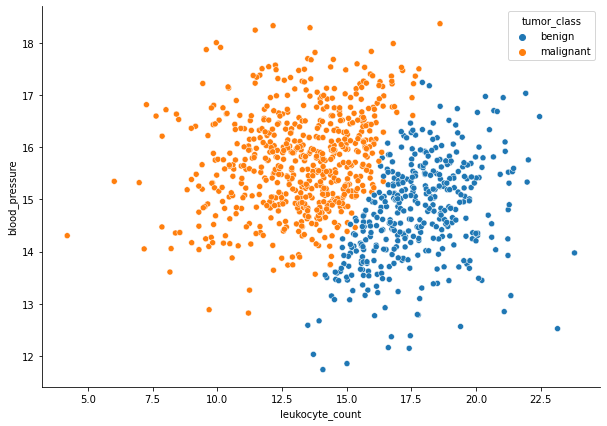

In [11]:
plt.figure(figsize = (10, 7))
sns.scatterplot(data = df, x = 'leukocyte_count', y = 'blood_pressure', hue = 'tumor_class')
sns.despine()

### Splitting

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [14]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


### Label Encoding
Create custom label encoding class instead of using scikit-learn's label encoder


In [19]:
class LabelEncoder(object):
  """
  Class to encode categorical data into numerical labels and decode the labels back to their original categories.

  Attributes:
      mapping (dict): A dictionary containing a mapping from each unique category to a numerical label.
      reverse_mapping (dict): A dictionary containing a mapping from each numerical label to its corresponding category.

  Methods:
      fit(data): Create a mapping from each unique category in the input data to a numerical label(value).
      transform(data): Convert a list of categorical values to numerical labels.
      reverse_transform(data): Convert a list of numerical labels to their original categorical values.

  """
  def __init__(self):
     self.mapping = {}
     self.reverse_mapping = {}

  def fit(self, data):
    # Get unique values in data
    unique_values = set(data)
    for value, label in enumerate(unique_values):
      self.mapping[label] = value
      self.reverse_mapping[value] = label

  def transform(self, data):
    return [self.mapping[lab] for lab in data]

  def reverse_transform(self, data):
    return [self.reverse_mapping[val] for val in data]

In [23]:
# Test label encoder

labels = ['cat', 'dog', 'cat', 'bird', 'bird', 'dog']
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
print(encoded_labels)
print(encoder.reverse_transform(encoded_labels))

[1, 2, 1, 0, 0, 2]
['cat', 'dog', 'cat', 'bird', 'bird', 'dog']


In [26]:
# Encode target data
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.mapping

{'benign': 0, 'malignant': 1}

In [27]:
y_train_enc = label_encoder.transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [29]:
# Test
print (f"y_train[0]: {y_train[0]}")
print (f"y_train_enc[0]: {y_train_enc[0]}")
print (f"decoded: {label_encoder.reverse_transform([y_train_enc[0]])}")

y_train[0]: malignant
y_train_enc[0]: 1
decoded: ['malignant']
